In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from tf_pose.estimator import TfPoseEstimator, PoseEstimator
from tf_pose.networks import get_graph_path
from tf_pose.common import CocoPart
import logging
import os
from tqdm import tqdm
from run_config import Run_types, Run_settings
from utils import load_batch, pose_loss_single_human, pose_loss_single_human_per_part, get_image_transform_mask
from plot_utils import bar_plot
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
logging.getLogger("tensorflow").setLevel(logging.CRITICAL)
logging.getLogger('TfPoseEstimatorRun').setLevel(logging.ERROR)
logging.getLogger('DeepExplain').setLevel(logging.ERROR)
logging.getLogger('TfPoseEstimator').setLevel(logging.ERROR)
logging.getLogger("wandb").setLevel(logging.ERROR)

Using tf version = 1.13.1


In [22]:
# run config
IMAGE_WIDTH, IMAGE_HEIGHT = 432, 368
NOISE_WIDTH, NOISE_HEIGHT = 200, 400
RESIZE_OUT_RATIO = 2.0
NUMBER_OF_TEST_IMAGES = 200

In [3]:
# the input image
sample_tensor = tf.placeholder(
    tf.float32,
    shape=(None, None, None, 3),
    name='sample'
)

# the current universal noise
universal_noise_tensor = tf.placeholder(
    tf.float32,
    shape=(None, None, None, 3),
    name='universal_noise'
)

# create a placeholder for the transform
transforms_tensor = tf.placeholder(
    tf.float32,
    shape=(None, 8),
    name='2d_transform'
)

mask_tensor = tf.placeholder(
    tf.bool,
    shape=(None, None, None, 3),
    name='mask'
)

# warp the noise 
warped_universal_noise_tensor = tf.contrib.image.transform(
    universal_noise_tensor,
    transforms_tensor,
    interpolation='NEAREST',
    output_shape=(IMAGE_HEIGHT, IMAGE_WIDTH),
    name='warped_universal_noise'
)


ax_input_overwrite_tensor = tf.where(
    mask_tensor,
    warped_universal_noise_tensor,
    sample_tensor,
    name='ax_input_overwrite'
)
estimator = TfPoseEstimator(
    get_graph_path('cmu'), 
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT), 
    trt_bool=False, input_overwrite_tensor=ax_input_overwrite_tensor, sample_image=sample_tensor)

In [4]:
def compute_metrics(test_image_targets, test_image_masks, test_image_transforms, universal_noise):
    error_values = []
    error_per_joint = []
    # compute total error metric 
    for image, mask, transform in tqdm(zip(test_image_targets, test_image_masks, test_image_transforms), total=len(test_image_targets)):
        detections = estimator.inference(image, resize_to_default=True, upsample_size=RESIZE_OUT_RATIO)

        detections_noise = estimator.inference(
            image, 
            resize_to_default=True, 
            upsample_size=RESIZE_OUT_RATIO, 
            transforms=[transform],
            universal_noise=[universal_noise],
            mask=[mask]
        )
        error_per_joint.append(pose_loss_single_human_per_part(detections_noise, detections))
        error_values.append(pose_loss_single_human(detections_noise, detections))
    return error_values, error_per_joint

In [5]:
universal_noises = []
error_values_list = []
error_per_joint_list = []

for run_type in Run_types:
    print(f"Running: {run_type.name}")
    
    run_settings = Run_settings(run_type)
    train_dir, test_dir, SNAPSHOT_NAME = run_settings.get_settings()
    print(f"test_dir={test_dir}")
    print(f"SNAPSHOT_NAME={SNAPSHOT_NAME}")
    [test_image_path_targets, 
     test_image_targets, 
     test_image_masks, 
     test_image_transforms] = get_image_transform_mask(test_dir, IMAGE_WIDTH, IMAGE_HEIGHT)
    
    universal_noise = np.load(SNAPSHOT_NAME)
    universal_noises.append(universal_noise)
    
    error_values, error_per_joint = compute_metrics(
        test_image_targets, 
         test_image_masks, 
         test_image_transforms,
        universal_noise
    )
    error_values_list.append(error_values)
    error_per_joint_list.append(error_per_joint)

Running: all_heat_paf_loss
test_dir=../data/generated/test
SNAPSHOT_NAME=../snapshots/universal_noise_with_warp.npy


100%|██████████| 200/200 [00:27<00:00,  7.33it/s]


Running: same_distance_heat_paf_loss
test_dir=../data/sameDistance/test
SNAPSHOT_NAME=../snapshots/universal_noise_with_warp_same_distance.npy


100%|██████████| 200/200 [00:26<00:00,  7.63it/s]


Running: same_roation_heat_paf_loss
test_dir=../data/sameRotation/test
SNAPSHOT_NAME=../snapshots/universal_noise_with_warp_same_rotation.npy


100%|██████████| 200/200 [00:26<00:00,  7.67it/s]


Running: same_distance_roation_heat_paf_loss
test_dir=../data/sameRotationDistance/test
SNAPSHOT_NAME=../snapshots/universal_noise_with_warp_same_rotation_distance.npy


100%|██████████| 200/200 [00:26<00:00,  7.61it/s]


Running: all_paf_loss
test_dir=../data/generated/test
SNAPSHOT_NAME=../snapshots/universal_noise_with_warp_PAF.npy


100%|██████████| 200/200 [00:26<00:00,  7.64it/s]


Running: same_distance_paf_loss
test_dir=../data/sameDistance/test
SNAPSHOT_NAME=../snapshots/universal_noise_with_warp_same_distance_PAF.npy


100%|██████████| 200/200 [00:26<00:00,  7.58it/s]


Running: same_roation_paf_loss
test_dir=../data/sameRotation/test
SNAPSHOT_NAME=../snapshots/universal_noise_with_warp_same_rotation_PAF.npy


100%|██████████| 200/200 [00:26<00:00,  7.64it/s]


Running: same_distance_roation_paf_loss
test_dir=../data/sameRotationDistance/test
SNAPSHOT_NAME=../snapshots/universal_noise_with_warp_same_rotation_distance_PAF.npy


100%|██████████| 200/200 [00:26<00:00,  7.60it/s]


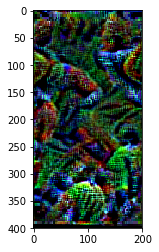

In [50]:
test = "../snapshots/universal_noise_with_warp_same_rotation_distance_PAF.npy"
test_image = np.load(test)
plt.imshow(test_image / 255)

In [6]:
run_names = list(map(lambda c: c.name, Run_types))
df = pd.DataFrame.from_records(
    data=np.transpose(np.array(error_values_list)), 
    columns=run_names
)


[Text(0.5, 1.0, 'Error distriubtion')]

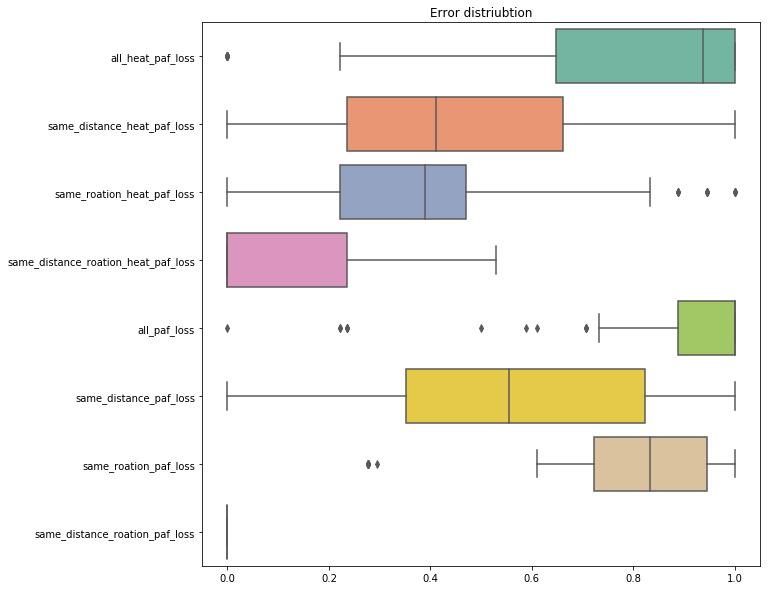

In [7]:
fig, ax = plt.subplots(figsize=(10, 10))
ax = sns.boxplot(data=df, orient="h", palette="Set2", ax=ax)
ax.set(title = 'Error distriubtion')

In [43]:
df.mean()
    coco_names = list(map(lambda c: c.name, CocoPart))


all_heat_paf_loss                      0.787259
same_distance_heat_paf_loss            0.497672
same_roation_heat_paf_loss             0.357316
same_distance_roation_heat_paf_loss    0.097600
all_paf_loss                           0.926050
same_distance_paf_loss                 0.589424
same_roation_paf_loss                  0.818395
same_distance_roation_paf_loss         0.000000
dtype: float64

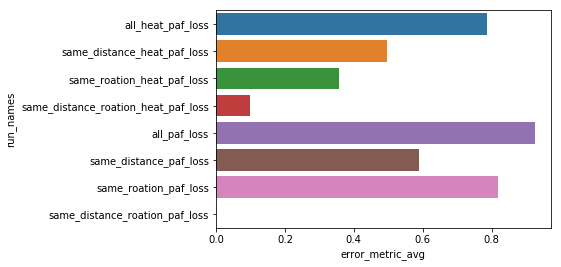

In [48]:
run_names = list(map(lambda c: c.name, Run_types))

df_means = pd.DataFrame({
    "run_names": run_names, 
    "error_metric_avg": df.mean()
    })
sns.barplot(y='run_names',  x='error_metric_avg', data=df_means,orient = 'h')

In [23]:
def get_error_per_joint_df(error_per_joint, run_type):
    coco_names = list(map(lambda c: c.name, CocoPart))
    df_obj = {
        "run_name": run_type.name 
    }
    for c_name in coco_names:
        df_obj[c_name] = 0
    for detection_result in error_per_joint:
        for joint_key in detection_result.keys():
            df_obj[CocoPart(joint_key).name] += detection_result[joint_key]
            
    for joint_key in df_obj.keys():
        if joint_key !=  "run_name":
            df_obj[joint_key] /= NUMBER_OF_TEST_IMAGES
            df_obj[joint_key] *= 100

    return df_obj

In [24]:
dict_list = []
for i, run_type in enumerate(Run_types):
    dict_list.append(get_error_per_joint_df(error_per_joint_list[i], run_type))
    
df_joints = pd.DataFrame(dict_list)

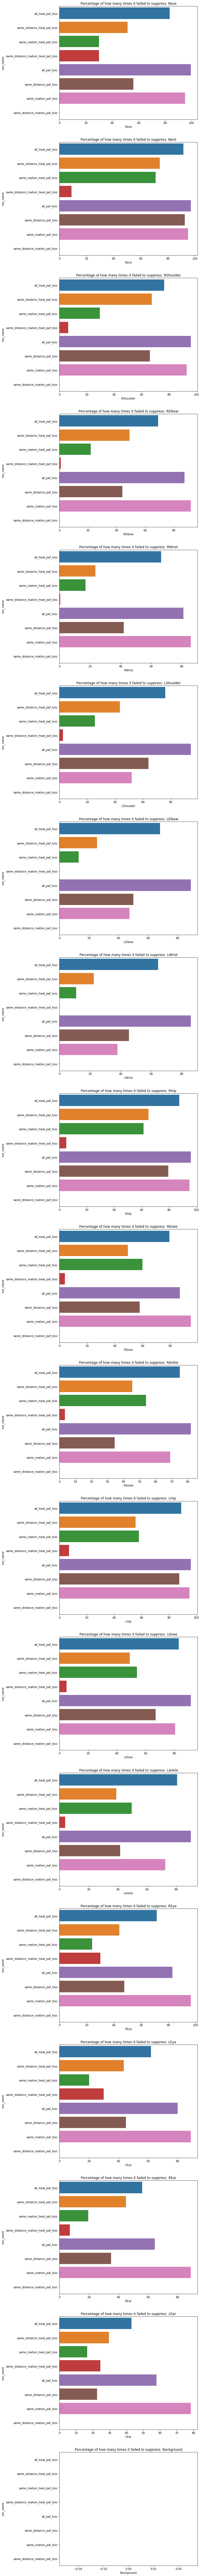

In [26]:
coco_names = list(map(lambda c: c.name, CocoPart))
n_cols = 1
n_rows = len(coco_names)
fig_scale = 3
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(3*n_cols*fig_scale, 3*n_rows*fig_scale))
plot_cnt = 0

for c_name in coco_names:
    ax = axes.flatten()[plot_cnt]
    ax = sns.barplot(y="run_name", x=c_name, data=df_joints, ax=ax, orient = 'h')
    ax.set_title(f'Percentage of how many times it failed to suppress: {c_name}')
    plot_cnt += 1
